## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import warnings
warnings.filterwarnings('ignore')


import os
from glob import glob
import json

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import sklearn.preprocessing
import sklearn.model_selection

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

import tensorflow.keras.layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## our modules
import scripts.tools as tools
import scripts.visualization as visualization
from scripts.my_image_generator import MyImageDataGenerator
import scripts.models as models

tf.autograph.set_verbosity(0)

## Handy constants
INPUT_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
TRAINING_BATCH = 32
VALIDATION_BATCH = 64

2021-11-02 17:20:16.828979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 17:20:16.834033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 17:20:16.834255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Do some early processing of your metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = tools.load_nih_dataset('data/')

# Split the 'Finding Labels' column into binary labels
all_xray_df, disease_labels = tools.split_findings(all_xray_df)

Scans found: 112120 , Total Headers 112120


In [3]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda flag: 'pneumonia' if flag == 1 else 'no finding')

In [4]:
print("NIH X-ray dataset has been loaded :")
all_xray_df.sample(3)

NIH X-ray dataset has been loaded :


Image Index         Finding Labels  Follow-up #  Patient ID  \
53941  00013608_022.png  Effusion|Infiltration           22       13608   
75880  00018615_006.png               Effusion            6       18615   
8412   00002229_003.png             No Finding            3        2229   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
53941           17              M            AP                 2500     2048   
75880           18              M            PA                 2992     2991   
8412            81              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia Infiltration  Mass  \
53941                        0.168  ...       0.0     0.0          1.0   0.0   
75880                        0.143  ...       0.0     0.0          0.0   0.0   
8412                         0.168  ...       0.0     0.0          0.0   0.0   

       No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
53941         0.0     0.0                 0.0        0.0           0.0   
75880         0.0     0.0                 0.0        0.0           0.0   
8412          1.0     0.0                 0.0        0.0           0.0   

       pneumonia_class  
53941       no finding  
75880       no finding  
8412        no finding  

[3 rows x 29 columns]

## Create your training and testing data:

In [5]:
training_df, fda_df = sklearn.model_selection.train_test_split(all_xray_df,
                                                              test_size=0.2,
                                                              stratify=all_xray_df['Pneumonia'])

train_df, valid_df = tools.split_train_validation(training_df,
                                         validation_size=0.4,
                                         train_positive_ratio=0.5,
                                         validation_positive_ratio=0.25)

In [6]:
n_training_samples = len(train_df)
n_training_positive = train_df.Pneumonia.sum()
n_training_negative = n_training_samples - n_training_positive
print(
    f'Training dataframe is composed of {n_training_samples} samples, in which {n_training_positive} are positive and {n_training_negative} are negative.')
print(
    f'This confirms then the {100 * n_training_positive / n_training_samples}/{100 * n_training_negative / n_training_samples}% split between positive and negative labels.')
train_df.head()

Training dataframe is composed of 1374 samples, in which 687.0 are positive and 687.0 are negative.
This confirms then the 50.0/50.0% split between positive and negative labels.


Image Index                     Finding Labels  Follow-up #  \
109877  00029889_000.png                          Pneumonia            0   
66816   00016508_057.png  Consolidation|Emphysema|Pneumonia           57   
103289  00027545_000.png    Cardiomegaly|Effusion|Pneumonia            0   
40451   00010531_012.png                          Pneumonia           12   
18676   00004959_003.png                Emphysema|Pneumonia            3   

        Patient ID  Patient Age Patient Gender View Position  \
109877       29889           44              F            PA   
66816        16508           52              F            AP   
103289       27545           57              F            PA   
40451        10531           28              F            AP   
18676         4959           85              F            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
109877                 2021     2021                     0.194311  ...   
66816                  2500     2048                     0.168000  ...   
103289                 2544     3056                     0.139000  ...   
40451                  3056     2544                     0.139000  ...   
18676                  2544     3056                     0.139000  ...   

        Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
109877       0.0     0.0          0.0   0.0         0.0     0.0   
66816        0.0     0.0          0.0   0.0         0.0     0.0   
103289       0.0     0.0          0.0   0.0         0.0     0.0   
40451        0.0     0.0          0.0   0.0         0.0     0.0   
18676        0.0     0.0          0.0   0.0         0.0     0.0   

        Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
109877                 0.0        1.0           0.0        pneumonia  
66816                  0.0        1.0           0.0        pneumonia  
103289                 0.0        1.0           0.0        pneumonia  
40451                  0.0        1.0           0.0        pneumonia  
18676                  0.0        1.0           0.0        pneumonia  

[5 rows x 29 columns]

In [7]:
n_validation_samples = len(valid_df)
n_validation_positive = valid_df.Pneumonia.sum()
n_validation_negative = n_validation_samples - n_validation_positive
print(
    f'Validation dataframe is composed of {n_validation_samples} samples, in which {n_validation_positive} are positive and {n_validation_negative} are negative.')
print(
    f'This confirms then the {100 * n_validation_positive / n_validation_samples}/{100 * n_validation_negative / n_validation_samples}% split between positive and negative labels.')
valid_df.head()

Validation dataframe is composed of 1832 samples, in which 458.0 are positive and 1374.0 are negative.
This confirms then the 25.0/75.0% split between positive and negative labels.


Image Index                        Finding Labels  Follow-up #  \
2683   00000710_003.png                    Fibrosis|Pneumonia            3   
62487  00015462_000.png  Consolidation|Infiltration|Pneumonia            0   
32405  00008470_008.png                             Pneumonia            8   
12845  00003369_012.png       Effusion|Infiltration|Pneumonia           12   
88434  00021895_001.png                             Pneumonia            1   

       Patient ID  Patient Age Patient Gender View Position  \
2683          710           57              F            PA   
62487       15462            3              F            AP   
32405        8470           30              F            AP   
12845        3369           50              F            AP   
88434       21895           32              M            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
2683                  2048     2500                        0.168  ...   
62487                 2048     2500                        0.168  ...   
32405                 2500     2048                        0.171  ...   
12845                 2500     2048                        0.168  ...   
88434                 2992     2991                        0.143  ...   

       Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
2683        1.0     0.0          0.0   0.0         0.0     0.0   
62487       0.0     0.0          1.0   0.0         0.0     0.0   
32405       0.0     0.0          0.0   0.0         0.0     0.0   
12845       0.0     0.0          1.0   0.0         0.0     0.0   
88434       0.0     0.0          0.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
2683                  0.0        1.0           0.0        pneumonia  
62487                 0.0        1.0           0.0        pneumonia  
32405                 0.0        1.0           0.0        pneumonia  
12845                 0.0        1.0           0.0        pneumonia  
88434                 0.0        1.0           0.0        pneumonia  

[5 rows x 29 columns]

In [8]:
n_fda_samples = len(fda_df)
n_fda_positive = fda_df.Pneumonia.sum()
n_fda_negative = n_fda_samples - n_fda_positive
print(
    f'FDA dataframe is composed of {n_fda_samples} samples, in which {n_fda_positive} are positive and {n_fda_negative} are negative.')
fda_df.head()

FDA dataframe is composed of 22424 samples, in which 286.0 are positive and 22138.0 are negative.


Image Index        Finding Labels  Follow-up #  Patient ID  \
19973   00005341_000.png              Fibrosis            0        5341   
23472   00006217_003.png            No Finding            3        6217   
69049   00017040_000.png  Atelectasis|Fibrosis            0       17040   
21034   00005612_009.png              Fibrosis            9        5612   
102321  00027244_000.png            No Finding            0       27244   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
19973            53              M            PA                 2048   
23472            22              M            AP                 2500   
69049            51              M            PA                 2662   
21034            57              F            PA                 2048   
102321           31              F            PA                 2714   

        Height]  OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia  \
19973      2500                        0.171  ...       1.0     0.0   
23472      2048                        0.171  ...       0.0     0.0   
69049      2688                        0.143  ...       1.0     0.0   
21034      2500                        0.168  ...       1.0     0.0   
102321     2991                        0.143  ...       0.0     0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
19973           0.0   0.0         0.0     0.0                 0.0        0.0   
23472           0.0   0.0         1.0     0.0                 0.0        0.0   
69049           0.0   0.0         0.0     0.0                 0.0        0.0   
21034           0.0   0.0         0.0     0.0                 0.0        0.0   
102321          0.0   0.0         1.0     0.0                 0.0        0.0   

        Pneumothorax  pneumonia_class  
19973            0.0       no finding  
23472            0.0       no finding  
69049            0.0       no finding  
21034            0.0       no finding  
102321           0.0       no finding  

[5 rows x 29 columns]

In [9]:
n_samples = len(all_xray_df)
n_positive = all_xray_df.Pneumonia.sum()
print(
    f'With respect to the complete dataset, training set accounts for {100 * n_training_positive / n_positive:0.2f}% of the pneumonia cases, validation set to {100 * n_validation_positive / n_positive:0.2f}% and FDA set to {100 * n_fda_positive / n_positive:0.2f}%')

With respect to the complete dataset, training set accounts for 48.01% of the pneumonia cases, validation set to 32.01% and FDA set to 19.99%


In [10]:
print('Wight of each class will be adjusted in the training phase by factors:')
class_weight = {1: float(n_training_negative) / (n_training_positive + n_training_negative),
                0: float(n_training_positive) / (n_training_positive + n_training_negative)}
print(class_weight)

steps_per_epoch = np.ceil(n_training_samples / TRAINING_BATCH)
validation_steps = np.ceil(n_validation_samples / VALIDATION_BATCH)
print(f'Training will be performed with {steps_per_epoch} steps_per_epoch and {validation_steps} validation_steps')

Wight of each class will be adjusted in the training phase by factors:
{1: 0.5, 0: 0.5}
Training will be performed with 43.0 steps_per_epoch and 29.0 validation_steps


# Now we can begin our model-building & training

#### Image augmentation

In [11]:
def make_train_gen(df):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    train_idg = MyImageDataGenerator(
        # rescale=1 / 255,
        horizontal_flip=True,
        vertical_flip=False,
        height_shift_range=0.1,
        width_shift_range=0.1,
        rotation_range=10,
        shear_range=0.1,
        zoom_range=0.1)

    gen = train_idg.flow_from_dataframe(dataframe=df,
                                              directory=None,
                                              x_col='path',
                                              y_col='pneumonia_class',
                                              class_mode='binary',
                                              target_size=IMG_SIZE,
                                              batch_size=TRAINING_BATCH,
                                              shuffle=True)

    return gen


def make_test_gen(df):
    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = MyImageDataGenerator(
        # rescale=1 / 255
    )

    gen = val_idg.flow_from_dataframe(dataframe=df,
                                          directory=None,
                                          x_col='path',
                                          y_col='pneumonia_class',
                                          class_mode='binary',
                                          target_size=IMG_SIZE,
                                          batch_size=VALIDATION_BATCH,
                                          shuffle=True)

    return gen

In [12]:
train_gen = make_train_gen(train_df)
val_gen = make_test_gen(valid_df)
fda_gen = make_test_gen(fda_df)

Found 1374 validated image filenames belonging to 2 classes.
Found 1832 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


#### Training-set images

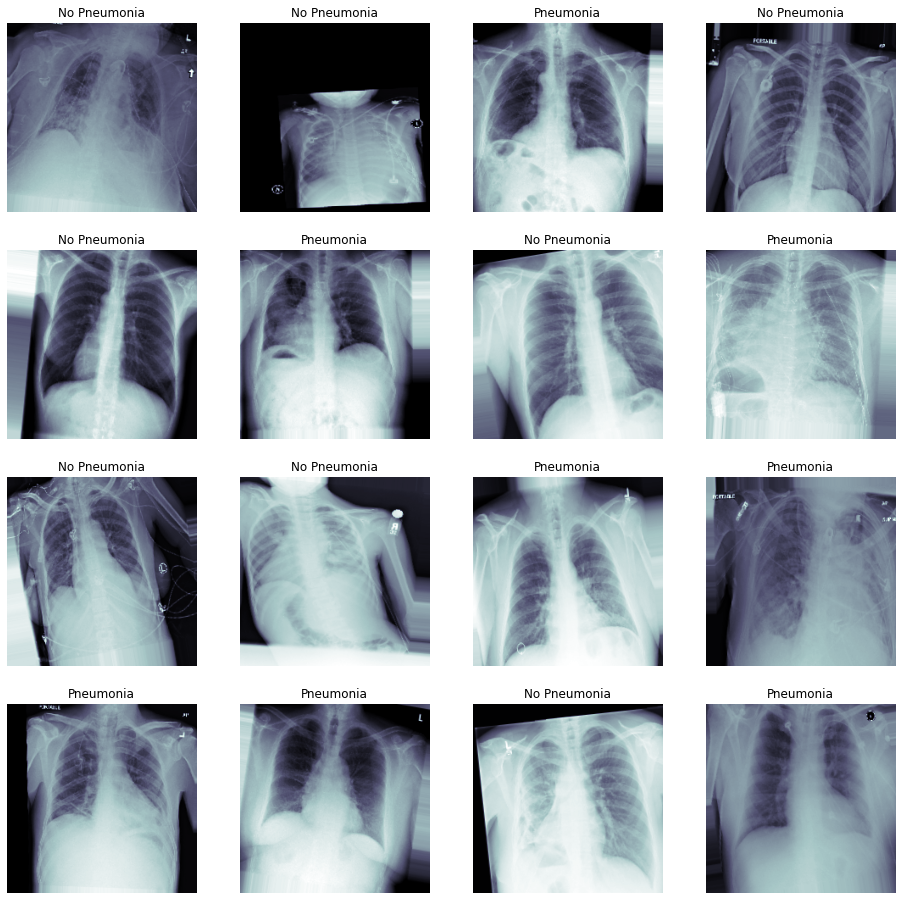

In [13]:
## May want to look at some examples of our augmented training data.
## This is helpful for understanding the extent to which data is being manipulated prior to training,
## and can be compared with how the raw data look prior to augmentation

trainX, trainY = next(train_gen)
visualization.batch_image_peak(trainX, trainY)

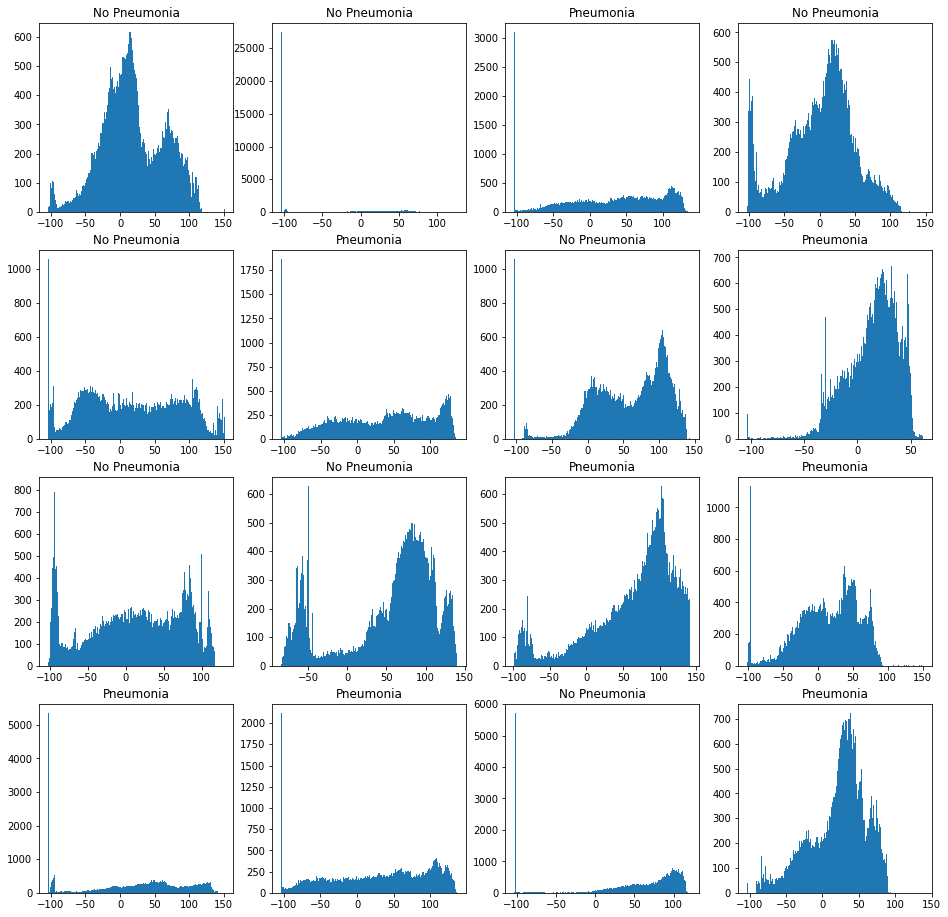

In [14]:
visualization.batch_histogram_peak(trainX, trainY)

#### Validation-set images


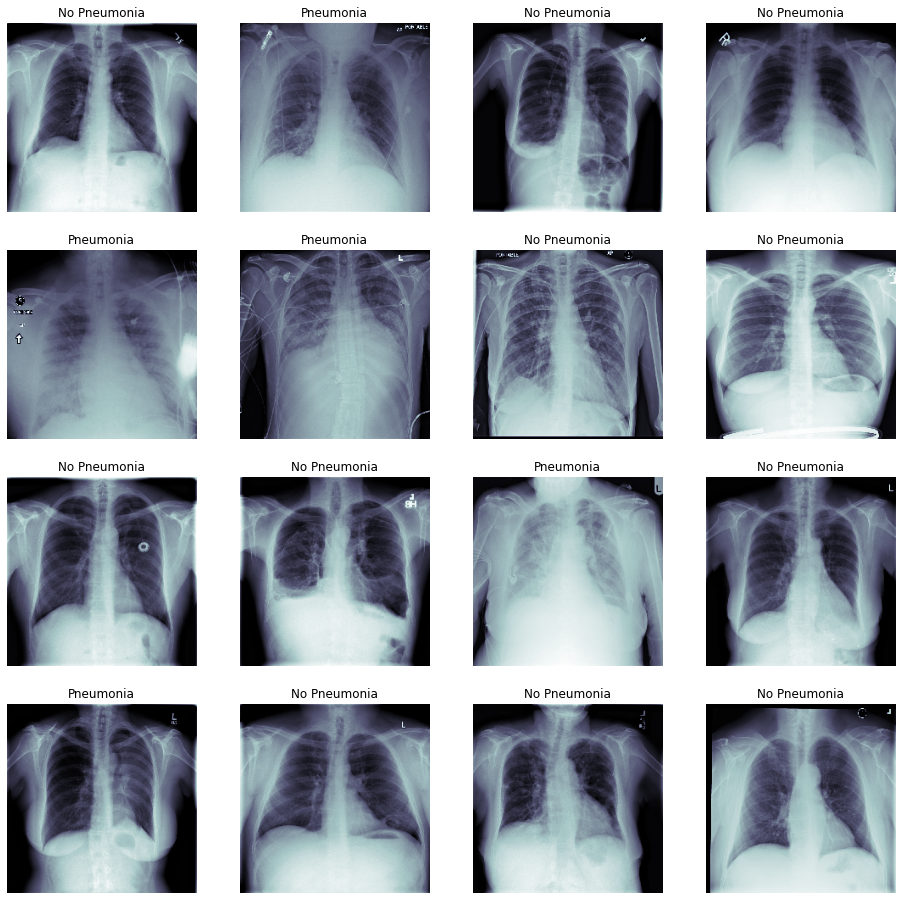

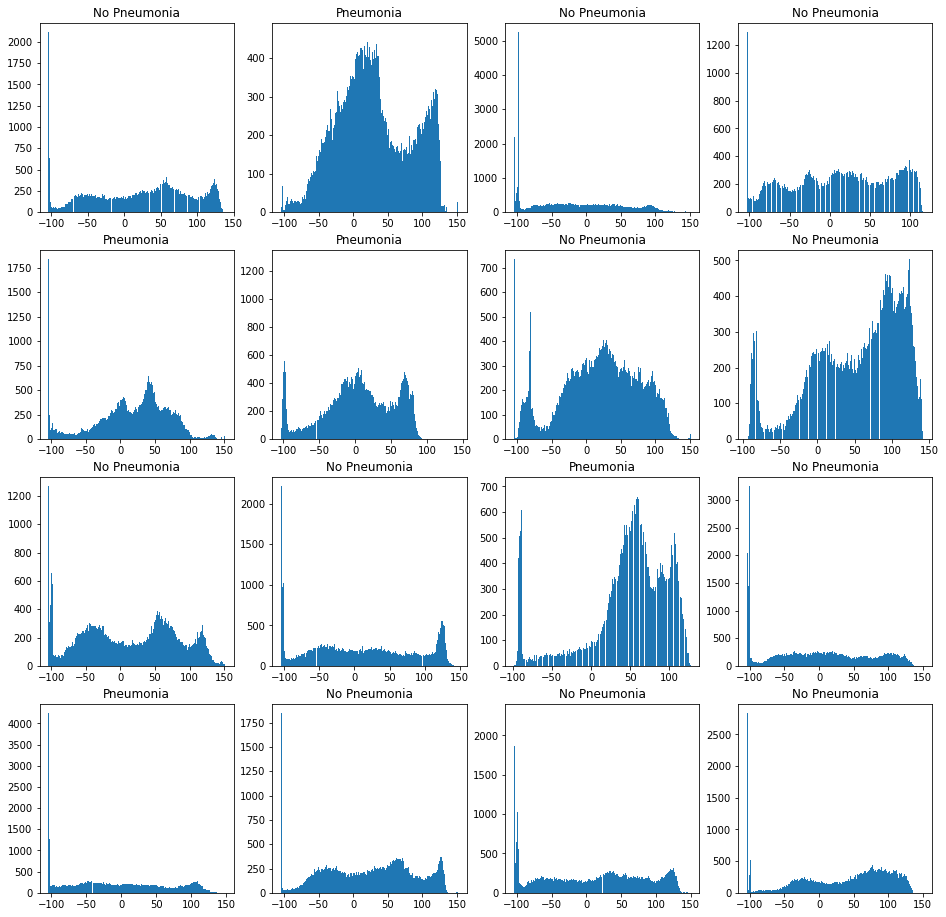

In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()
visualization.batch_image_peak(valX, valY)
visualization.batch_histogram_peak(valX, valY)

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning


In [16]:
DropoutFactor = 0.5
WeightDecay = 1e-6

inputs = tf.keras.Input(shape=INPUT_SHAPE)

pre_trained = models.VGG16(INPUT_SHAPE)
# pre_trained = models.ResNet50(INPUT_SHAPE)
# preprocessing = pre_trained.get_preprocessing()
# load pre-trained model
base_model = pre_trained.get_base_model()
base_model.trainable = False

# x = preprocessing(inputs)
# x = base_model(x, training=False)
x = tf.keras.layers.Flatten(name='Flatten')(base_model.output)
x = tf.keras.layers.Dropout(DropoutFactor)(x)
outputs = tf.keras.layers.Dense(1, name='prediction', activation='sigmoid')(x)
my_model = tf.keras.Model(base_model.inputs, outputs)

print(my_model.summary())
for layer in my_model.layers:
    print(f'{layer.name}: {layer.trainable}')

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2021-11-02 17:20:31.356936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 17:20:31.357223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 17:20:31.357476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 17:20:31.357646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [17]:
PATIENCE = 15

METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
EVALUATION_MODE = 'auto'

weight_path = "{}.best.hdf5".format('warmup')

checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

early = EarlyStopping(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                      mode=EVALUATION_MODE,
                      patience=PATIENCE)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log/initial', histogram_freq=1)

reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                                                 factor=0.5,
                                                 patience=5,
                                                 verbose=1,
                                                 mode='auto')

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

2021-11-02 17:20:31.842206: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-02 17:20:31.842241: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-02 17:20:31.842267: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-11-02 17:20:31.842695: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-11-02 17:20:31.960896: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-02 17:20:31.961050: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [18]:
import tensorflow_addons as tfa

# Compile the model!
optimizer = Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training!

In [19]:
## train your model
MAX_EPOCHS = 50

history = my_model.fit(train_gen,
                       validation_data=val_gen,
                       epochs=MAX_EPOCHS,
                       class_weight=class_weight,
                       steps_per_epoch=steps_per_epoch,
                       validation_steps=validation_steps,
                       callbacks=callbacks_list
                       )

2021-11-02 17:20:32.524751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-02 17:20:33.682247: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-02 17:20:33.887607: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-02 17:20:34.073882: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2021-11-02 17:20:34.761990: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is 

 1/43 [..............................] - ETA: 7:25 - loss: 1.3301 - binary_accuracy: 0.6250

2021-11-02 17:20:43.172936: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-02 17:20:43.172966: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 19s - loss: 1.4425 - binary_accuracy: 0.6094 

2021-11-02 17:20:43.646108: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-02 17:20:43.646415: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-02 17:20:43.677772: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 150 callback api events and 147 activity events. 
2021-11-02 17:20:43.680072: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-02 17:20:43.683006: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/initial/train/plugins/profile/2021_11_02_17_20_43

2021-11-02 17:20:43.684957: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/initial/train/plugins/profile/2021_11_02_17_20_43/perrusi-PC.trace.json.gz
2021-11-02 17:20:43.690757: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

43/43 [==============================] - ETA: 0s - loss: 2.4891 - binary_accuracy: 0.5080  

2021-11-02 17:21:10.700321: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2021-11-02 17:21:11.012647: W tensorflow/core/common_runtime/bfc_allocator.cc:338] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


43/43 [==============================] - 85s 2s/step - loss: 2.4891 - binary_accuracy: 0.5080 - val_loss: 2.5679 - val_binary_accuracy: 0.6250

Epoch 00001: val_loss improved from inf to 2.56788, saving model to warmup.best.hdf5
Epoch 2/50
43/43 [==============================] - 39s 911ms/step - loss: 2.3473 - binary_accuracy: 0.4942 - val_loss: 2.5136 - val_binary_accuracy: 0.6141

### Fine-tunning

In [20]:
my_model.load_weights(weight_path)  # load early stopped weights

In [21]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_top_layers = pre_trained.get_fine_tuning_top_layer()

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-fine_tune_top_layers]:
    layer.trainable = False
for layer in base_model.layers[-fine_tune_top_layers:]:
    layer.trainable = True

my_model.summary()
print(len(my_model.trainable_variables))

Number of layers in the base model:  19
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooli

In [22]:
# reset generators
train_gen.reset()
val_gen.reset()

# re-compile the model with a smaller learning rate
optimizer = Adam(learning_rate=1e-6)
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## re-train your model
MAX_FINE_TUNED_EPOCHS = history.epoch[-1] + 50


weight_path = "{}.best.hdf5".format('fine_tunning')
checkpoint = ModelCheckpoint(weight_path,
                             monitor=METRIC_TO_MONITOR_FOR_PERFORMANCE,
                             verbose=1,
                             save_best_only=True,
                             mode=EVALUATION_MODE,
                             save_weights_only=False)

callbacks_list = [checkpoint, early, tensorboard_callback, reduce_LR]

history_fine = my_model.fit(train_gen,
                            validation_data=val_gen,
                            initial_epoch=history.epoch[-1],
                            epochs=MAX_FINE_TUNED_EPOCHS,
                            callbacks=callbacks_list,
                            class_weight=class_weight,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            )

Epoch 44/93
 1/43 [..............................] - ETA: 2:07 - loss: 2.3825 - binary_accuracy: 0.5955

2021-11-02 17:51:15.169848: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-02 17:51:15.169869: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/43 [>.............................] - ETA: 23s - loss: 2.3569 - binary_accuracy: 0.5939 

2021-11-02 17:51:15.770772: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-02 17:51:15.771029: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-02 17:51:15.819149: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 247 callback api events and 246 activity events. 
2021-11-02 17:51:15.822989: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-02 17:51:15.827258: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/initial/train/plugins/profile/2021_11_02_17_51_15

2021-11-02 17:51:15.830299: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/initial/train/plugins/profile/2021_11_02_17_51_15/perrusi-PC.trace.json.gz
2021-11-02 17:51:15.838525: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

43/43 [==============================] - 41s 905ms/step - loss: 1.8168 - binary_accuracy: 0.5611 - val_loss: 1.9523 - val_binary_accuracy: 0.5895

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [23]:
# base_model.trainable = False
# for layer in base_model.layers:
#     layer.trainable = False

## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

In [24]:
# reset generators
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_predY = my_model.predict(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_predY = my_model.predict(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_predY = my_model.predict(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 256s 730ms/step

In [25]:
# reset generators
train_gen.reset()
val_gen.reset()
fda_gen.reset()

train_eval = my_model.evaluate(train_gen, batch_size=TRAINING_BATCH, verbose=True)
val_eval = my_model.evaluate(val_gen, batch_size=VALIDATION_BATCH, verbose=True)
fda_eval = my_model.evaluate(fda_gen, batch_size=VALIDATION_BATCH, verbose=True)


351/351 [==============================] - 225s 639ms/step - loss: 0.6872 - binary_accuracy: 0.5806

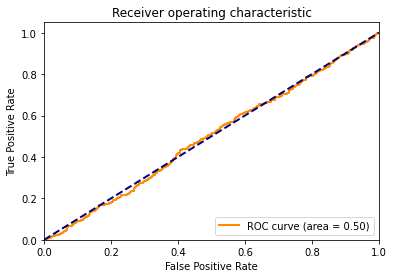

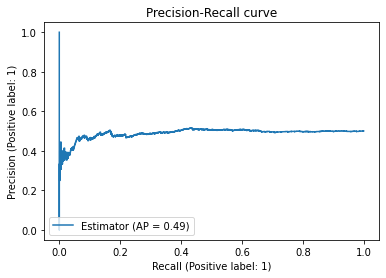

In [45]:
## plot figures
visualization.plot_auc(train_gen.labels, train_predY)
visualization.precision_recall(train_gen.labels, train_predY)
# visualization.plot_history(history)

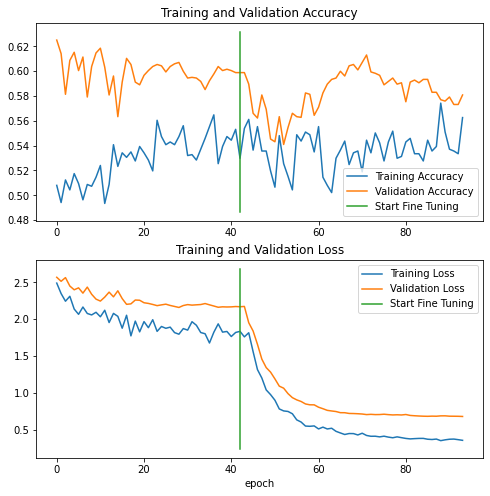

In [86]:
initial_epochs = history.epoch[-1]
acc = history.history['binary_accuracy'] + history_fine.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] + history_fine.history['val_binary_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('history.png')

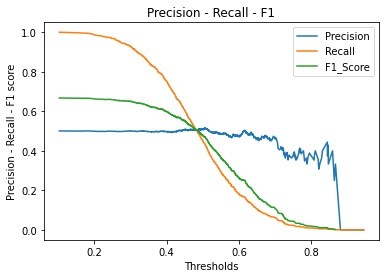

In [79]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(train_gen.labels, train_predY)
compute_f1 = lambda precision, recall: 2 * (precision * recall) / (precision + recall)
f1_scores = compute_f1(precision, recall)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1_Score')
plt.xlabel('Thresholds')
plt.ylabel('Precision - Recall - F1 score')
plt.title("Precision - Recall - F1")
plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
plt.show()

In [80]:
# remove NAN
f1_scores = f1_scores[~np.isnan(f1_scores)]


Chosen F1 score 0.47030878859857483, precision 0.5147826086956522, recall 0.43085880640465796 for threshold 0.5067846179008484


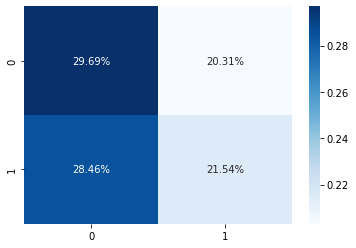

In [81]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return index

# idx = np.argmax(f1_scores)
# idx = find_nearest_idx(f1_scores, 0.5)
idx = np.argmax(precision[:-1])

threshold = thresholds[idx]
print(f'Chosen F1 score {f1_scores[idx]}, precision {precision[idx+1]}, recall {recall[idx+1]} for threshold {threshold}')

visualization.confusion_matrix(train_gen.labels, train_predY > threshold)
plt.show()

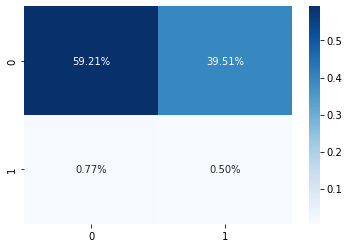

In [82]:
# Apply it to the FDA set
visualization.confusion_matrix(fda_gen.labels, fda_predY > threshold)
plt.show()


1/1 [==============================] - 0s 23ms/step


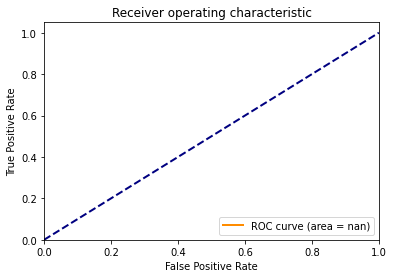

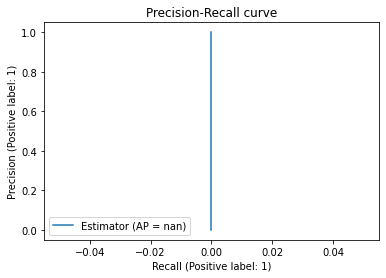

In [83]:
fda_gen.reset()
valX, valY = fda_gen.next()
batchY = my_model.predict(valX, batch_size=VALIDATION_BATCH, verbose=True)
visualization.plot_auc(valY, batchY)
visualization.precision_recall(valY, batchY)



Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

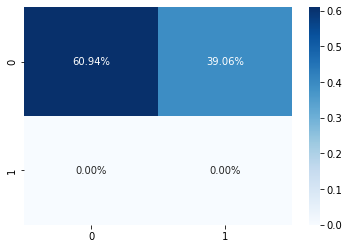

In [84]:
# precision, recall, thresholds = sklearn.metrics.precision_recall_curve(valY, batchY)
# compute_f1 = lambda precision, recall: 2 * (precision * recall) / (precision + recall)
# f1_scores = compute_f1(precision, recall)
#
# plt.plot(thresholds, precision[:-1], label='Precision')
# plt.plot(thresholds, recall[:-1], label='Recall')
# plt.plot(thresholds, 2 * f1_scores[:-1], label='F1_Score')
# plt.xlabel('Thresholds')
# plt.ylabel('Precision - Recall - F1 score')
# plt.title("Precision - Recall - F1")
# plt.legend(['Precision', 'Recall', 'F1_Score'], loc='upper right')
# plt.show()
#
# # idx = np.argmax(np.abs(np.diff(f1_scores)))
# idx = np.argmax(f1_scores)
#
# threshold = thresholds[idx]
# print(f'Maximum F1 score {f1_scores[idx]} for threshold {threshold}')

visualization.confusion_matrix(valY, batchY > threshold)
plt.show()

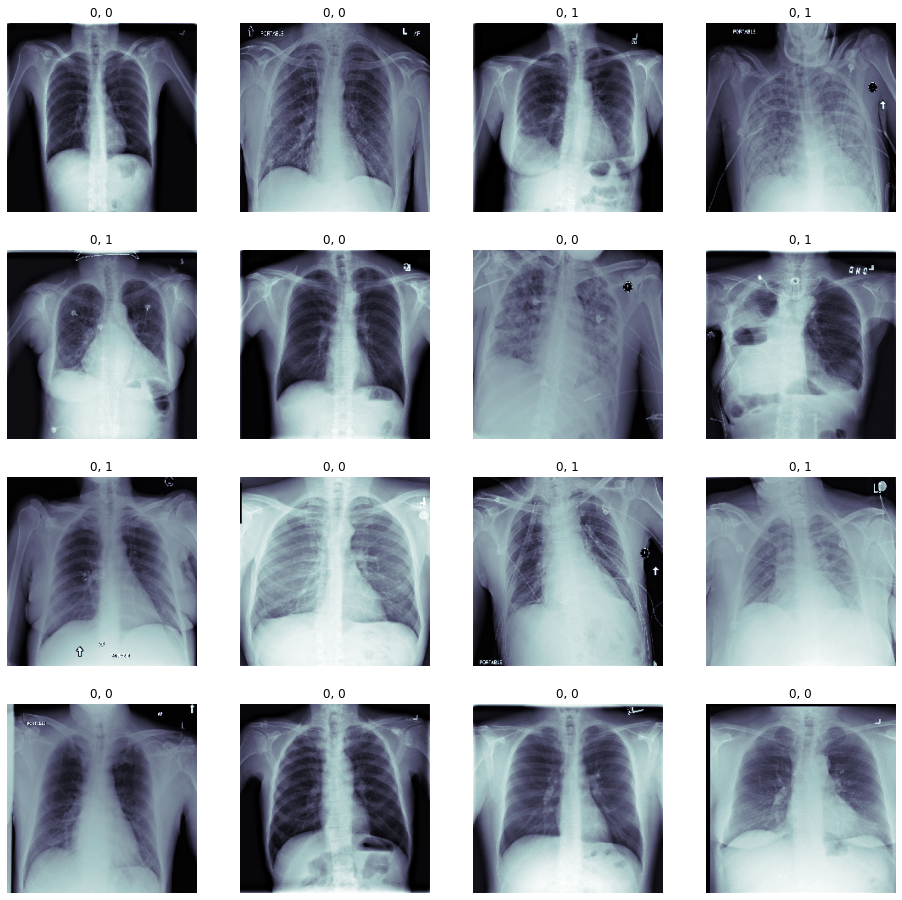

In [85]:
## Let's look at some examples of true vs. predicted with our best model:

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:, :, 0], cmap='bone')
    if c_y == 1:
        if batchY[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if batchY[i] > threshold:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i = i + 1

In [43]:
## Just save model architecture to a .json:

my_model.save("my_model.h5")

In [44]:
import json

# Save it under the form of a json file
# json.dump(history.history, open('history.json', 'w'))
# json.dump(history_fine.history, open('history_fine.json', 'w'))

### References
* https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

